In [1]:
# import modules for project
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pytesseract

In [2]:
# helper function to show image
def show(img, title="", gray=False):
    plt.figure(figsize=(8, 6))
    if gray:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

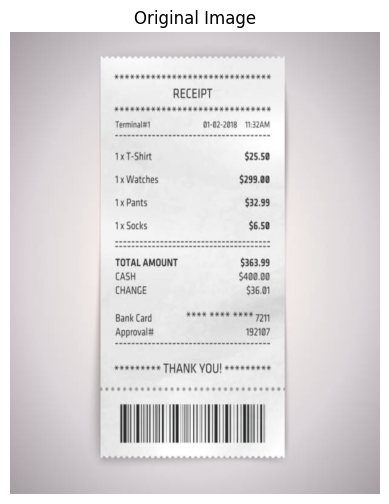

In [3]:
# load the image

image_path = "/home/krushang/radhey/love/personal/Doc-Scanner-Project/assets/img/test.jpg"
image = cv2.imread(image_path)

if image is None:
    raise FileNotFoundError("Image not found. Check the path!")

# Resize to manageable size
image = cv2.resize(image, (800, 1000))
orig = image.copy()

show(image, "Original Image")

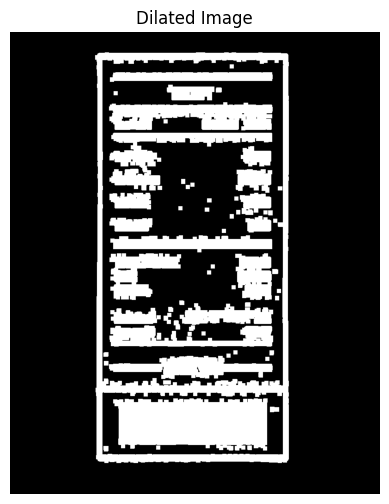

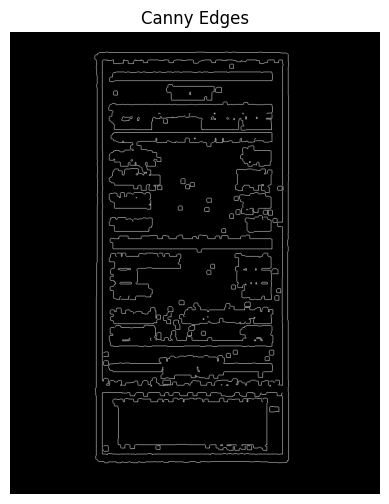

In [4]:
# preprocessing

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# adaptive threshold and invert
thresh = cv2.adaptiveThreshold(blurred, 255,
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY, 11, 2)
thresh = cv2.bitwise_not(thresh)

# dilation to emphasize contours
kernel = np.ones((5, 5), np.uint8)
dilated = cv2.dilate(thresh, kernel, iterations=2)
show(dilated, "Dilated Image", gray=True)

# edge detection
edged = cv2.Canny(dilated, 75, 200)
show(edged, "Canny Edges", gray=True)


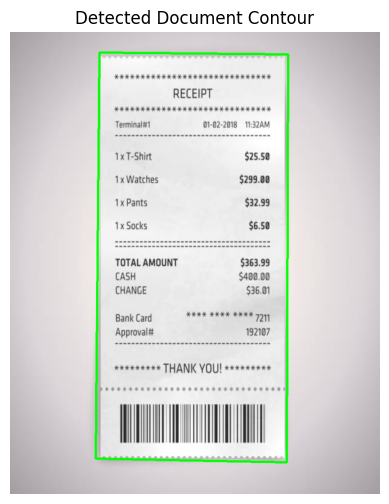

In [5]:
# find all contours
contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

doc_contour = None
max_area = 0
min_contour_area = 50000  # <-- Updated threshold for large shapes

# Try to find largest 4-point contour based on area and shape
for contour in contours:
    area = cv2.contourArea(contour)
    if area > min_contour_area:
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)

        if len(approx) == 4:
            if area > max_area:
                doc_contour = approx
                max_area = area

# If no clean 4-point found, fallback to largest rectangle-ish contour
if doc_contour is None:
    print("[Fallback] Trying convex hull approach...")
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > min_contour_area:
            hull = cv2.convexHull(contour)
            peri = cv2.arcLength(hull, True)
            approx = cv2.approxPolyDP(hull, 0.02 * peri, True)

            if len(approx) == 4:
                doc_contour = approx
                break

def manual_corner_selection(image):
    pts = []

    def click_event(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN and len(pts) < 4:
            pts.append([x, y])
            cv2.circle(image, (x, y), 5, (0, 255, 0), -1)
            cv2.imshow("Click 4 corners", image)

    clone = image.copy()
    cv2.imshow("Click 4 corners", clone)
    cv2.setMouseCallback("Click 4 corners", click_event)
    while len(pts) < 4:
        cv2.waitKey(1)
    cv2.destroyAllWindows()
    return np.array(pts, dtype=np.float32)

# Final fallback — manual corner selection
if doc_contour is None:
    print("[Manual Mode] Could not detect document. Please click 4 corners.")
    doc_contour = manual_corner_selection(image)

# debug draw
contour_img = orig.copy()
if doc_contour.shape != (4, 1, 2):
    doc_contour = doc_contour.reshape((4, 1, 2)).astype(np.int32)

cv2.drawContours(contour_img, [doc_contour], -1, (0, 255, 0), 3)
show(contour_img, "Detected Document Contour")


In [6]:
# reorder point for transform
def reorder(pts):
    pts = pts.reshape((4, 2))
    new_pts = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    d = np.diff(pts, axis=1)

    new_pts[0] = pts[np.argmin(s)]  # Top-left
    new_pts[2] = pts[np.argmax(s)]  # Bottom-right
    new_pts[1] = pts[np.argmin(d)]  # Top-right
    new_pts[3] = pts[np.argmax(d)]  # Bottom-left

    return new_pts

ordered_pts = reorder(doc_contour)


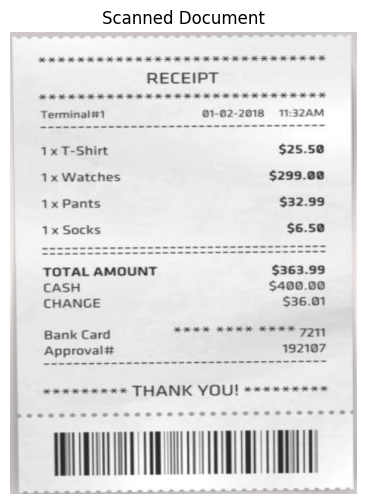

In [7]:
# perspective transform
width, height = 600, 800
destination_pts = np.float32([[0, 0], [width, 0], [width, height], [0, height]])

matrix = cv2.getPerspectiveTransform(ordered_pts, destination_pts)
scanned_doc = cv2.warpPerspective(orig, matrix, (width, height))

show(scanned_doc, "Scanned Document")


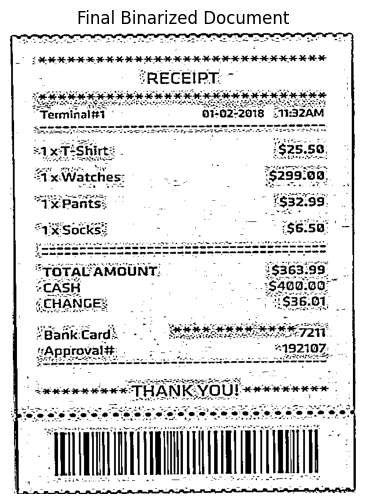

In [8]:
# enhance output
gray_doc = cv2.cvtColor(scanned_doc, cv2.COLOR_BGR2GRAY)
binarized = cv2.adaptiveThreshold(gray_doc, 255,
                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY, 11, 2)

show(binarized, "Final Binarized Document", gray=True)


In [10]:
save_dir = "outputs"
os.makedirs(save_dir, exist_ok=True)

# ask user for desired format
format_choice = input("Choose export format [jpg/png/pdf]: ").strip().lower()

if format_choice in ["jpg", "png"]:
    ext = format_choice
    cv2.imwrite(os.path.join(save_dir, f"scanned_document_color.{ext}"), scanned_doc)
    cv2.imwrite(os.path.join(save_dir, f"scanned_document_binarized.{ext}"), binarized)
    print(f"Both color and binarized images saved as scanned_document_color.{ext} and scanned_document_binarized.{ext} in 'assets/' folder.")

elif format_choice == "pdf":
    # Convert both versions to PIL and save as PDF
    rgb_img = cv2.cvtColor(scanned_doc, cv2.COLOR_BGR2RGB)
    pil_color = Image.fromarray(rgb_img)

    pil_binary = Image.fromarray(binarized).convert("RGB")  # binarized is grayscale

    pdf_path_color = os.path.join(save_dir, "scanned_document_color.pdf")
    pdf_path_binary = os.path.join(save_dir, "scanned_document_binarized.pdf")

    pil_color.save(pdf_path_color, "PDF", resolution=100.0)
    pil_binary.save(pdf_path_binary, "PDF", resolution=100.0)

    print("Both color and binarized PDFs saved in 'assets/' folder.")

else:
    print("Unsupported format selected. Please choose from [jpg, png, pdf].")


Choose export format [jpg/png/pdf]:  jpg


Both color and binarized images saved as scanned_document_color.jpg and scanned_document_binarized.jpg in 'assets/' folder.
